In [13]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
import os
from sklearn.metrics import log_loss

In [14]:
d = "C:\kaggle_data\credit_card"
lst = os.listdir(d)
print(lst)
train = pd.read_csv(d + '\\' +lst[3])
test = pd.read_csv(d + '\\' +lst[2])
ss = pd.read_csv(d + '\\' +lst[1])
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']


# 전처리

### family_type
- 'Married', 'Civil marriage'
- 'Separated', 'Single / not married', 'Widow'

In [15]:
train['family_type'].unique()

array(['Married', 'Civil marriage', 'Separated', 'Single / not married',
       'Widow'], dtype=object)

In [16]:
# Married, Civil marriage
train['income_per_size'] = np.log(train['income_total']/train['family_size'])
test['income_per_size'] = np.log(test['income_total']/test['family_size'])
train.loc[(train['family_type']=='Married')|(train['family_type']=='Civil marriage'),'income_per_size']\
= train['income_per_size'] * 2

test.loc[(test['family_type']=='Married')|(test['family_type']=='Civil marriage'),'income_per_size']\
= test['income_per_size'] * 2

In [17]:
def simple_marry(x):
    if x == 'Married' or x =='Civil marriage':
        return '0'
    else:
        return '1'

In [18]:
for df in [train,test]:
    df['family_binary'] = df['family_type'].apply(simple_marry)

In [19]:
# income_total을 로그변환 한 새로운 feature log_income
# 기존 칼럼 삭제
train['log_income'] = np.log(train['income_total'])
train = train.drop('income_total',1)
test['log_income'] = np.log(test['income_total'])
test = test.drop('income_total',1)

In [20]:
# car와 reality를 합친 새로운 칼럼 careality
train['careality'] = train['car'] + train['reality']
train = train.drop(['car', 'reality'],1)

test['careality'] = test['car'] + test['reality']
test = test.drop(['car', 'reality'],1)

In [21]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

In [22]:
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [23]:
test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

# 모델링, 학습

In [24]:
train.columns

Index(['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone',
       'phone', 'email', 'family_size', 'begin_month', 'credit',
       'income_per_size', 'log_income', 'gender_F', 'gender_M',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'edu_type_Academic degree',
       'edu_type_Higher education', 'edu_type_Incomplete higher',
       'edu_type_Lower secondary', 'edu_type_Secondary / secondary special',
       'family_type_Civil marriage', 'family_type_Married',
       'family_type_Separated', 'family_type_Single / not married',
       'family_type_Widow', 'house_type_Co-op apartment',
       'house_type_House / apartment', 'house_type_Municipal apartment',
       'house_type_Office apartment', 'house_type_Rented apartment',
       'house_type_With parents', 'occyp_type_Accountants',
       'occyp_type_Cleaning staff', 'occyp_type_Cooking staff',
       'occy

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
losses=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    losses.append(log_loss(y_valid, lgb.predict_proba(X_valid)))
    print(f'================================================================================\n\n')
print(sum(losses)/5)

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.646009	valid_1's multi_logloss: 0.749493
[200]	training's multi_logloss: 0.55779	valid_1's multi_logloss: 0.731471
[300]	training's multi_logloss: 0.495709	valid_1's multi_logloss: 0.723063
[400]	training's multi_logloss: 0.4432	valid_1's multi_logloss: 0.721638
Early stopping, best iteration is:
[404]	training's multi_logloss: 0.441529	valid_1's multi_logloss: 0.721517


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.642517	valid_1's multi_logloss: 0.760614
[200]	training's multi_logloss: 0.556102	valid_1's multi_logloss: 0.74657
[300]	training's multi_logloss: 0.491893	valid_1's multi_logloss: 0.743572
Early stopping, best iteration is:
[309]	training's multi_logloss: 0.486562	valid

In [ ]:
# 이전 점수
# 0.7341944423873108
# 0.7331765265764199

In [22]:
ss.iloc[:,1:]=0
for fold in range(5):
    ss.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [36]:
ss.to_csv('baseline_ips_marriage.csv', index=False)

In [35]:
sns.factorplot(x='credit',hue='family_type',data=train,y='income_total')

ValueError: Could not interpret input 'income_total'

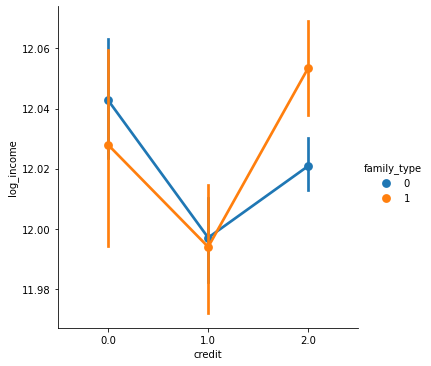

In [36]:
sns.factorplot(x='credit',hue='family_type',data=train,y='log_income')

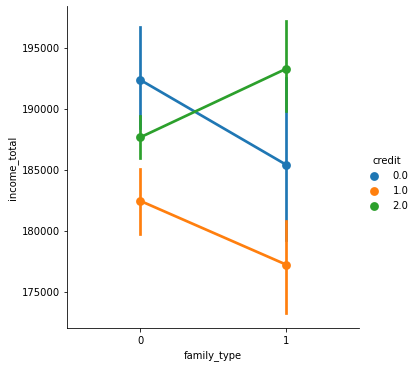

In [32]:
sns.factorplot(hue='credit',x='family_type',data=train,y='income_total')